# Intensity Control

In this notebook we will evaluate the signal quality of the intensity controller and estimate an error by comparison with voltage differences in intensity measurements.

In [1]:
import os
import numpy as np
import pandas as pd

datadir = '../../dataset/intensity'
figuredir = '../../figure/intensity/control'

from matplotlib import dates as mdates

os.makedirs(figuredir, exist_ok=True)

In [2]:
long = pd.read_hdf(os.path.join(datadir, 'control.h5'), 'long')
long.time = pd.to_datetime(long.time, format='%Y-%m-%d_%H%M%S')

short = pd.read_hdf(os.path.join(datadir, 'control.h5'), 'short')
short.time = pd.to_datetime(short.time, format='%Y-%m-%d_%H%M%S')

In [3]:
long.voltage.mean(), long.voltage.min(), long.voltage.max(), long.voltage.std(), long.voltage.std() / long.voltage.mean()

(6.790721721811591,
 4.883208036031497,
 6.864006856101877,
 0.09186888609865777,
 0.013528589428657886)

In [4]:
short.voltage.mean(), short.voltage.min(), short.voltage.max(), short.voltage.std(), short.voltage.std() / short.voltage.mean()

(6.789301355971451,
 6.765777897547424,
 6.822276358793229,
 0.012768993779543474,
 0.001880752246814417)

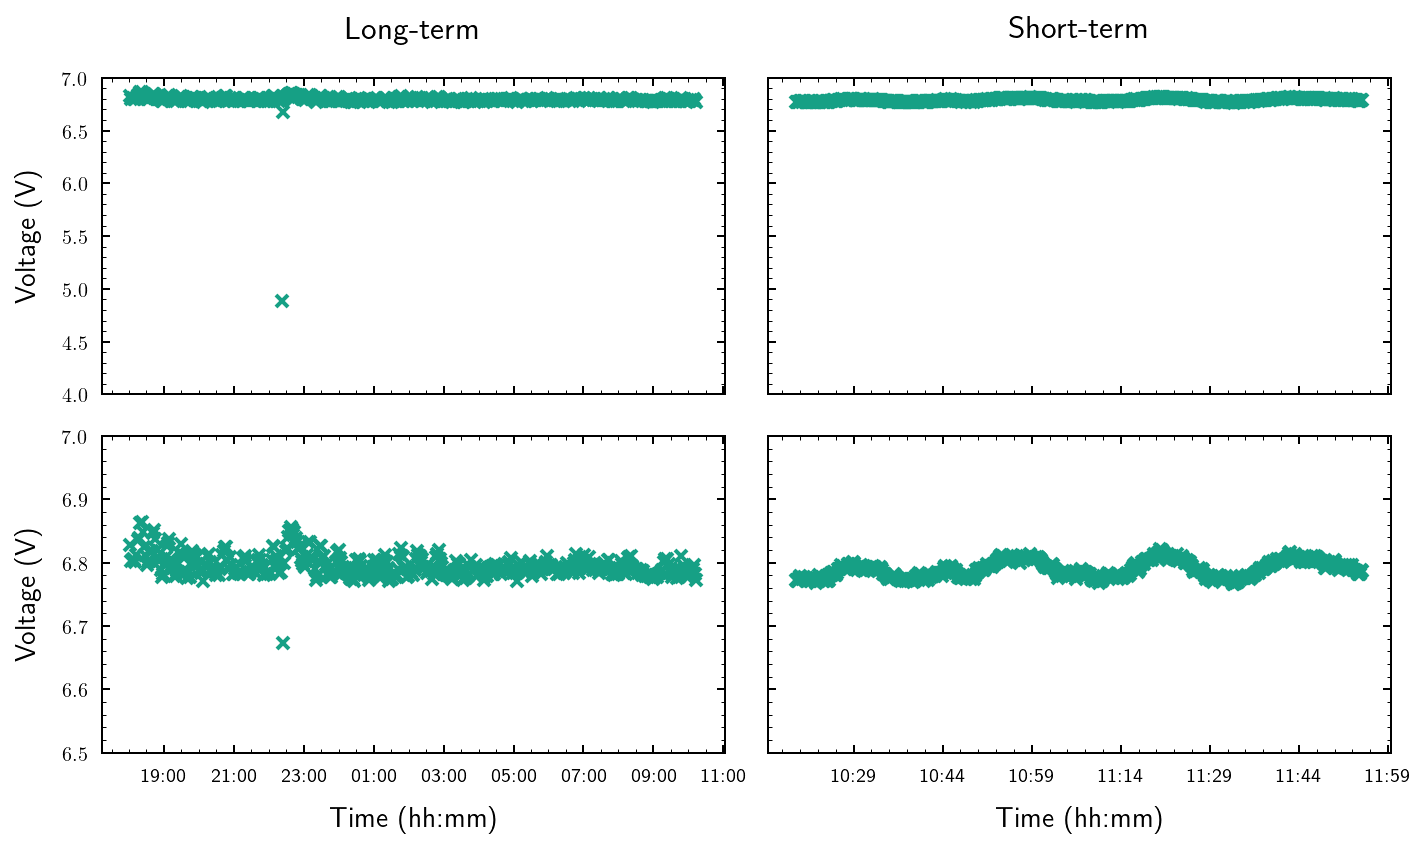

In [23]:
fig = plt.figure(figsize=(10, 6))
fig.autofmt_xdate()

ax0 = fig.add_subplot(221)
ax0.set_title('Long-term')
ax0.plot(long.time.astype('O'), long.voltage, marker='x', color='#16a085', linestyle='none')
ax0.set_ylim(4, 7)

ax1 = fig.add_subplot(222)
ax1.set_title('Short-term')
ax1.plot(short.time.astype('O'), short.voltage, marker='x', color='#16a085', linestyle='none')
ax1.set_ylim(4, 7)

ax2 = fig.add_subplot(223)
ax2.plot(long.time.astype('O'), long.voltage, marker='x', color='#16a085', linestyle='none')
ax2.set_ylim(6.5, 7)

ax3 = fig.add_subplot(224)
ax3.plot(short.time.astype('O'), short.voltage, marker='x', color='#16a085', linestyle='none')
ax3.set_ylim(6.5, 7)

ax2.get_shared_x_axes().join(ax0, ax2)
ax2.set_xlabel('Time (hh:mm)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax0.set_xticklabels([])

ax3.get_shared_x_axes().join(ax1, ax3)
ax3.set_xlabel('Time (hh:mm)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xticklabels([])

ax0.get_shared_y_axes().join(ax0, ax1)
ax0.set_ylabel('Voltage (V)')
ax1.set_yticklabels([])

ax2.get_shared_y_axes().join(ax2, ax3)
ax2.set_ylabel('Voltage (V)')
ax3.set_yticklabels([])

plt.tight_layout()
plt.savefig(os.path.join(figuredir, 'long-short.pdf'))
plt.show()

In [61]:
ts = 60 * (60 * short.time.dt.hour + short.time.dt.minute) + short.time.dt.second
ts -= ts.min()

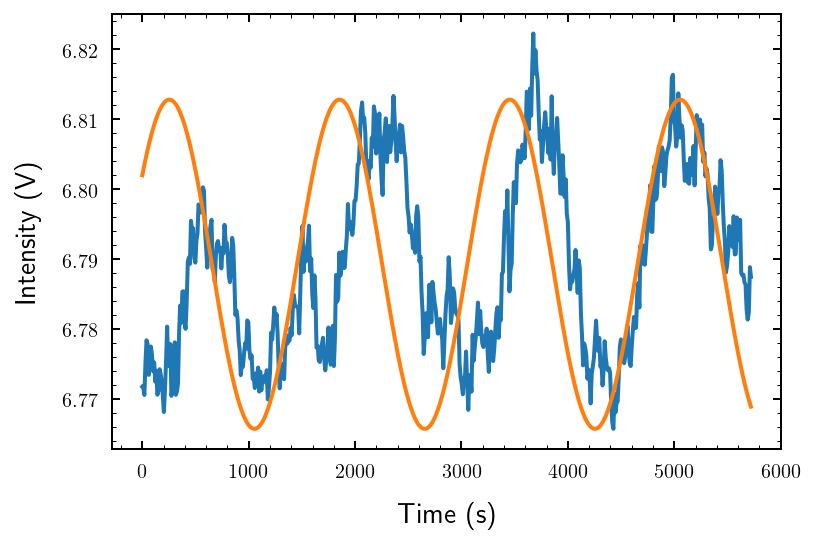

In [134]:
f = 1/1600

plt.plot(ts.values, short.voltage.values)
plt.plot(ts.values, short.voltage.mean() + (short.voltage.mean() - short.voltage.min())*np.cos(2*np.pi*f*ts.values-1))
plt.xlabel('Time (s)')
plt.ylabel('Intensity (V)')
plt.show()

In [138]:
df = pd.read_hdf(os.path.join(datadir, 'anticipated-frequency.h5'), 'vsweep')

t = df.time
U = df['voltage@100.00MHz'] * 10**(-2)

def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

U_l = reject_outliers(long.voltage - long.voltage.mean())
U_s = reject_outliers(short.voltage - short.voltage.mean())

In [139]:
U.mean(), U.min(), U.max(), U.std(), U.std() / U.mean()

(0.019526885502323434,
 -0.00025038878080000163,
 0.030022416646399996,
 0.00540612233669803,
 0.2768553303625801)

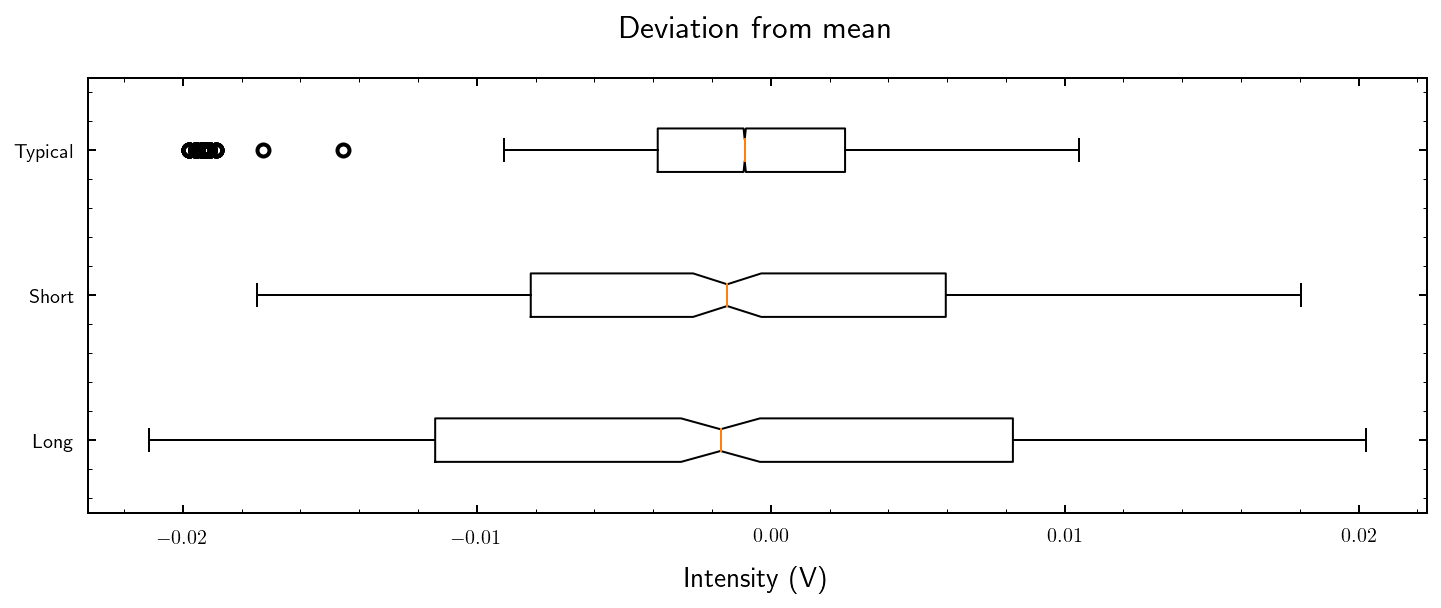

In [142]:
plt.figure(figsize=(12, 4))

plt.title('Deviation from mean')
plt.boxplot([U_s, U_l, U - U.mean()], notch=1, vert=False)
plt.yticks([1, 2, 3], ['Long', 'Short', 'Typical'])
plt.xlabel('Intensity (V)')

plt.savefig(os.path.join(figuredir, 'deviation.pdf'))
plt.show()